# A regression problem
This notebook will explore regression when $p>n$. The problem presents a case where the amount of features is much higher than the amount of samples. There is two problems may arise when $p>n$

- **Overfitting:** The linear regression fit with will have high variancer (overfitting) and will not be able to generalize well to new data
- **Interpretability:** The computed coeficient may shows that each feature contributes somewhat to the target variable. However, suppose that domain knowledge tells us that the data and target is generated sparsely (There is only a few relevant features). In this case it preferable to seek a smaller subset of features that predicts the target variable while ignoring the rest of the features by setting the respective coeficient to zero

The regression model is not overfitt since it performed well on the test set (see R2 score in the cell below). The coefficients print show however that each features contributes somewhat in predicting the target variable. The features that are not part of the true model should ideally be ignored by setting the respective coeficent set to zero. This is mainly done for *interpretation* purposes mentioned earlier

The data used in this project is generated *sparsely* where the amount of *relevant features*  actually predicting target variable is much lower than the amount of features included in the data. *Feature selection* refers to selecting a smaller subset of features in order to tackle the two points mentioned above. There are three approaches to feature selection: *Filter*, *Wrapping*, and *Embedded methods*. 

## Loading and exploring the data

In [1]:
import statsmodels.api as sm
from scipy import stats
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split



npz = np.load("Data.npz")

#print(npz.files)
X = npz['X']
y = npz['y']

npz.close()


print('The shape of X is: {0}'.format(X.shape))
print('This means that X has {0} number of samples and {1} features'.format(np.size(X,0), np.size(X,1)))


### Center the target variable so the regression model does not have to fit the intercept
### Standardize X for easier interpretation
y = y-np.mean(y, axis=0) 
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Standardize data (easier to set the l1_ratio parameter)





#########  Get predicitive performance with ordianry least squares
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regr = LinearRegression(fit_intercept = False,normalize=False)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print('R2 score on the test set is {0} \n'.format(r2_score(y_test, y_pred)))
print('The coeficients computed is \n \n {0}'.format(regr.coef_))



The shape of X is: (190, 467)
This means that X has 190 number of samples and 467 features
R2 score on the test set is 0.9758291772852806 

The coeficients computed is 
 
 [ 0.59569598 -1.00357214  0.7223991  -0.14966974  1.20667965  0.80184061
 -0.15068191  0.39717054  1.60982597 -1.10183611  0.62939516  1.97049745
  0.90007977 -2.03687505  0.56350631  0.76959168 -0.54448183 -0.89888026
 -0.12313418 -2.85342674 -1.38597852 -0.48696656  0.35780281  0.02047037
 -0.87225615  0.39101754 -0.17227436  1.11572678  0.00866822 -0.22198969
 -0.3545405   0.57199537 -0.47413     0.24501961  0.35129545 -0.5473705
  0.67371947 -0.41303638  0.40184809 -1.14718918 -0.14733596  0.43385426
 -1.24923614 -1.0019771   1.52531214  1.41936185 -0.93915345 -0.27769305
  1.50136047 -0.09423844  1.64007995 -1.40050659  1.19463643  1.3036579
  0.66744679  0.3351683   0.20197236 -0.18995048  0.52187284 -0.37932018
  0.07302387  0.8945454  -0.31819784  0.1347317  -0.74277778  0.62021997
  0.67650469  0.33314002  0

## Filtering
*Filtering* can be described as fast and easy. This approach often uses univariate statistical measures to determine *usefule features* by filtering out features which are below a certain threshold value. A **caveat** of this approach is that it only focuses on one feature at a time, while the true model might be produced from a specific subset of feature. <br/>

The following are some useful measures used in filtering 

- **Fscore:** Features that correlate most with the target variable will compute a higher Fscore.
- **Mutual information:** Measures the information (measured in shannon bits) gained in a samples after observing an



In [2]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, f_regression
from heapq import nlargest


metrics = (('mutal information', mutual_info_regression), 
           ('Fscore' ,f_regression),)

NumberOfFeaturesToKeep = 10;

for name,metric in metrics:
    
    
    ##################  Applying filtering ##################################################
    SelectKBestFitted = SelectKBest(metric, k=NumberOfFeaturesToKeep).fit(X, y)
    features_scores = SelectKBestFitted.scores_
    print('The top {0} ranked features when measuring {1} were {2}'.format(NumberOfFeaturesToKeep,name,
                                                                          sorted((-features_scores).argsort()[:NumberOfFeaturesToKeep])))
    
    
    ###################  Test the predictive performance on the selected features ##########
    X_new = SelectKBest(metric, k=NumberOfFeaturesToKeep).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    regr = LinearRegression(fit_intercept = False,normalize=False)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    print('The reg score {0} \n \n '.format(r2_score(y_test, y_pred)))



The top 10 ranked features when measuring mutal information were [16, 44, 119, 120, 121, 122, 127, 131, 168, 346]
The reg score 0.9461149419285225 
 
 
The top 10 ranked features when measuring Fscore were [10, 28, 117, 118, 119, 124, 131, 283, 346, 442]
The reg score 0.9674263486091049 
 
 


## Wrapping
A wrapping approach is an iterative method which **combines subset of features with a learning algorithm** to determine feature relevance by observing the predictive performance of the learned model. Ideally all subsets of features should be fitted with the learning algorithm. However this is computationally expensive in high dimensional data since the amount of subsets to train  grows exponentially with increasing features.  <br/>

There are different search strategies for selecting a subset of feature in each iteration. A *forward stepwise search* (used in this project) starts with an intercept, and the feature which will most likey improve the fit is added to the model [1]. Each the algorithm will terminate when $p=k$ ($k$ is given by the user before the algorithm is run). Choosing a value for $k$ will be a decision between having larger bias or variance in the model. A smaller $k$ means that less features are used in order to sacrifice some bias to reduce variance.

- In this regression case where $p>n$ forward stepwise selection will be used

A **caveat** of wrapper approaches is that it compleltley discards certain features, which leads to higher variance

In [3]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import pprint
pp = pprint.PrettyPrinter(indent=4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Parameter k controls after how many features the algorithm should terminate. 
### The final model will be trained on k features
k = 10


### The wrapper will use ordinary least squares as the learning algorithm
regr = LinearRegression(fit_intercept = False,normalize=False)

### Performs forward stepwise search
sfs1 = SFS(regr, k_features=k, forward=True, floating=False, verbose=2,scoring='r2', cv=0)
sfs1 = sfs1.fit(X_train, y_train)

pp.pprint(sfs1.subsets_)




###################  Test the predictive performance features subset found by the wrapper ##########
X_new = X[:,list(sfs1.subsets_[10]['feature_idx'])]
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=2019)
regr = LinearRegression(fit_intercept = False,normalize=False)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print('The reg score {0} \n \n '.format(r2_score(y_test, y_pred)))



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 467 out of 467 | elapsed:    0.4s finished

[2019-09-10 22:16:19] Features: 1/10 -- score: 0.8883669094404214[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 466 out of 466 | elapsed:    0.2s finished

[2019-09-10 22:16:19] Features: 2/10 -- score: 0.938117012023337[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 465 out of 465 | elapsed:    0.2s finished

[2019-09-10 22:16:19] Features: 3/10 -- score: 0.957959059756007[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1

{   1: {   'avg_score': 0.8883669094404214,
           'cv_scores': array([0.88836691]),
           'feature_idx': (118,),
           'feature_names': ('118',)},
    2: {   'avg_score': 0.938117012023337,
           'cv_scores': array([0.93811701]),
           'feature_idx': (118, 442),
           'feature_names': ('118', '442')},
    3: {   'avg_score': 0.957959059756007,
           'cv_scores': array([0.95795906]),
           'feature_idx': (21, 118, 442),
           'feature_names': ('21', '118', '442')},
    4: {   'avg_score': 0.9667769873475618,
           'cv_scores': array([0.96677699]),
           'feature_idx': (21, 118, 347, 442),
           'feature_names': ('21', '118', '347', '442')},
    5: {   'avg_score': 0.9727569474324278,
           'cv_scores': array([0.97275695]),
           'feature_idx': (21, 118, 347, 442, 450),
           'feature_names': ('21', '118', '347', '442', '450')},
    6: {   'avg_score': 0.9793907185527875,
           'cv_scores': array([0.97939072]

[Parallel(n_jobs=1)]: Done 458 out of 458 | elapsed:    0.3s finished

[2019-09-10 22:16:22] Features: 10/10 -- score: 0.9887573569634022

## Embedded methods with regularization
Embedded methods incoroporates feature selection as part of the learning algorithm itself (feature selection is *embedded* within the learning algorithm). This is often done by adding a penalty term as shown below

\begin{equation}
\beta = arg \min_{\beta \in R^p} \quad \underbrace{\frac{1}{2}||y - \beta X||_{2}^{2}}_{\text{Ordinary least squares}}  \quad  + \underbrace{\lambda ||\beta||_q^q}_{\text{Penalty term}}
\end{equation}

The penalty term includes $\lambda$ is a hyperparameter that is set before training. This hyperparameter controls how much each coefficient should shrink. If $q=1$ then the coefficients can be shrank down to zero for high values of $\lambda$. If $q=2$ then some coefficients will shrink towards zero for high values of $\lambda$. The first case of $q=1$ presents a method for selecting useful features by having non-zero coefficient after the model has been fitted, also known as *Lasso*.


Given the following two conditions, the lasso is able to find the true coefficients of the data

- The data should be generated **sparsley** (only from a small subset of the features): 
- Correlation between the relevant features and the unrelevant features should be small.

Plotting the regularization path will give information which lambda to select in order to maintain a certain number of coefficient. The regularization path plotted in the cell below shows that at $\lambda=55$ there will be two non-zero coefficients. At $\lambda=27$ there will be 10 non zero-coeficients.


- The lasso is useful because it can perform features selection, but it introduces bias when predicting




Computing regularization path


<Figure size 432x288 with 0 Axes>

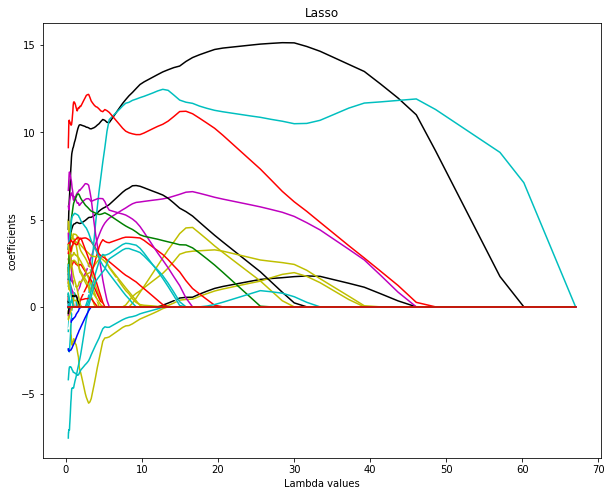

The top 10 non-zero coefficients features lasso selected were [14, 28, 117, 118, 126, 131, 133, 141, 442, 459]
The reg score 0.7648797309006786 
 
 


C:\Users\chris\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The top 10 highest valued coefficients features lasso selected were [118, 132, 133, 134, 148, 252, 379, 442, 450, 453]
The reg score when using CV 0.9926918573292518 
 
 
Amount of non-zero coefficients 60


C:\Users\chris\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [4]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lasso_path, enet_path
from matplotlib import pyplot as plt
from itertools import cycle
from sklearn import linear_model, datasets

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
import pyprind
import math
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


###################  Computing the regularization path  ####################
eps = 5e-3  # the smaller it is the longer is the path
print("Computing regularization path")
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps, fit_intercept=False)





################## Plotting the regularization path ###################
%matplotlib inline
plt.figure(1)
plt.figure(figsize=(10,8))

#neg_log_alphas_lasso = -np.log10(alphas_lasso)
colors = cycle(['b', 'g', 'r', 'c', 'm','y','k','w'])
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(alphas_lasso, coef_l, c=c)

plt.xlabel('Lambda values')
plt.ylabel('coefficients')
plt.title('Lasso')
plt.axis('tight')
plt.show()






#################  Testing the predictive performance of the non-zero coefficietn found by lasso  ###########################
regr = linear_model.Lasso(alpha=27, fit_intercept = False)
regr.fit(X_train,y_train)

print('The top 10 non-zero coefficients features lasso selected were {0}'.format(sorted((-regr.coef_).argsort()[:10])))
y_pred = regr.predict(X_test)
print('The reg score {0} \n \n '.format(r2_score(y_test, y_pred)))






################  Testing lasso with CV   #########################################

regr = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
regr.fit(X_train,y_train)

print('The top 10 highest valued coefficients features lasso selected were {0}'.format(sorted((-regr.coef_).argsort()[:10])))
y_pred = regr.predict(X_test)
print('The reg score when using CV {0} \n \n '.format(r2_score(y_test, y_pred)))
print('Amount of non-zero coefficients {0}'.format(np.size(np.nonzero(regr.coef_),1)))


    
    


## References
[1] T. Hastie, R. Tibshirani, and J. H. Friedman,Elements of statistical learn-ing.    Springer, 2009.